# 13.2b: Radial Density Profile from Hero Token

**What is the true scale of the cluster core?**

Instead of picking arbitrary adjacency thresholds, we measure the intrinsic structure by computing the radial density profile from a "hero token" ('&', token 38, confirmed dead).

For each training step:
1. Compute distances from token 38 to all other tokens
2. Sort by distance
3. Plot cumulative count vs radius

**What to look for:**
- **Kinks** (slope changes) = boundaries between core/halo
- **Plateaus** (flat sections) = gaps with no tokens
- **The knee** = natural threshold for "connected" vs "escaped"

## Parameters

In [32]:
# Data source
TRAINING_DATA_PATH = "../tensors/Lil_Gatsby/13.1b_training_data.safetensors"  # SGD data

# Hero token
HERO_TOKEN_ID = 38  # '&' character, confirmed dead

# Steps to analyze
SNAPSHOT_STEPS = [0, 1, 10, 50, 100, 500, 1000, 5000, 10000]

# Visualization
DPI = 200
COLORMAP = 'viridis'

RANDOM_SEED = 42

## Imports

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import safe_open

np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [34]:
print(f"Loading training data: {TRAINING_DATA_PATH}")

with safe_open(TRAINING_DATA_PATH, framework='pt', device='cpu') as f:
    embeddings_bf16 = f.get_tensor('embeddings')
    dead_token_ids = f.get_tensor('dead_token_ids')
    live_token_ids = f.get_tensor('live_token_ids')
    recorded_steps = f.get_tensor('recorded_steps')

# Convert to float32
embeddings = embeddings_bf16.to(torch.float32)

n_steps, n_tokens, n_dims = embeddings.shape

print(f"  Embeddings: {embeddings.shape}")
print(f"  Steps: {recorded_steps[0]} to {recorded_steps[-1]}")
print(f"\n✓ Data loaded")

# Verify hero token is dead
is_dead = HERO_TOKEN_ID in dead_token_ids
print(f"\nHero token {HERO_TOKEN_ID} ('&') is {'DEAD' if is_dead else 'LIVE'}")
if not is_dead:
    print("WARNING: Hero token is not dead!")

Loading training data: ../tensors/Lil_Gatsby/13.1b_training_data.safetensors
  Embeddings: torch.Size([10001, 128, 64])
  Steps: 0 to 10000

✓ Data loaded

Hero token 38 ('&') is DEAD


## Compute Radial Density Profiles

In [35]:
def compute_radial_profile(embeddings, hero_id, step_indices):
    """
    Compute sorted distances from hero token at specified steps.
    
    Returns:
        profiles: dict mapping step_idx -> sorted distances [n_tokens-1]
    """
    profiles = {}
    
    for step_idx in step_indices:
        # Get embeddings at this step
        emb = embeddings[step_idx]  # [n_tokens, n_dims]
        
        # Hero token position
        hero_pos = emb[hero_id]
        
        # Distances to all tokens
        distances = torch.norm(emb - hero_pos, p=2, dim=1)
        
        # Remove hero token itself (distance = 0)
        mask = torch.arange(n_tokens) != hero_id
        distances = distances[mask]
        
        # Sort
        distances_sorted, _ = torch.sort(distances)
        
        profiles[step_idx] = distances_sorted.numpy()
    
    return profiles

# Find step indices for our snapshots
step_indices = []
for target_step in SNAPSHOT_STEPS:
    # Find closest recorded step
    idx = (recorded_steps - target_step).abs().argmin().item()
    step_indices.append(idx)

print(f"Computing radial profiles for {len(step_indices)} snapshots...")
profiles = compute_radial_profile(embeddings, HERO_TOKEN_ID, step_indices)

print(f"\n✓ Profiles computed")

Computing radial profiles for 9 snapshots...

✓ Profiles computed


## Visualizations

### Cumulative Count vs Radius (All Snapshots)

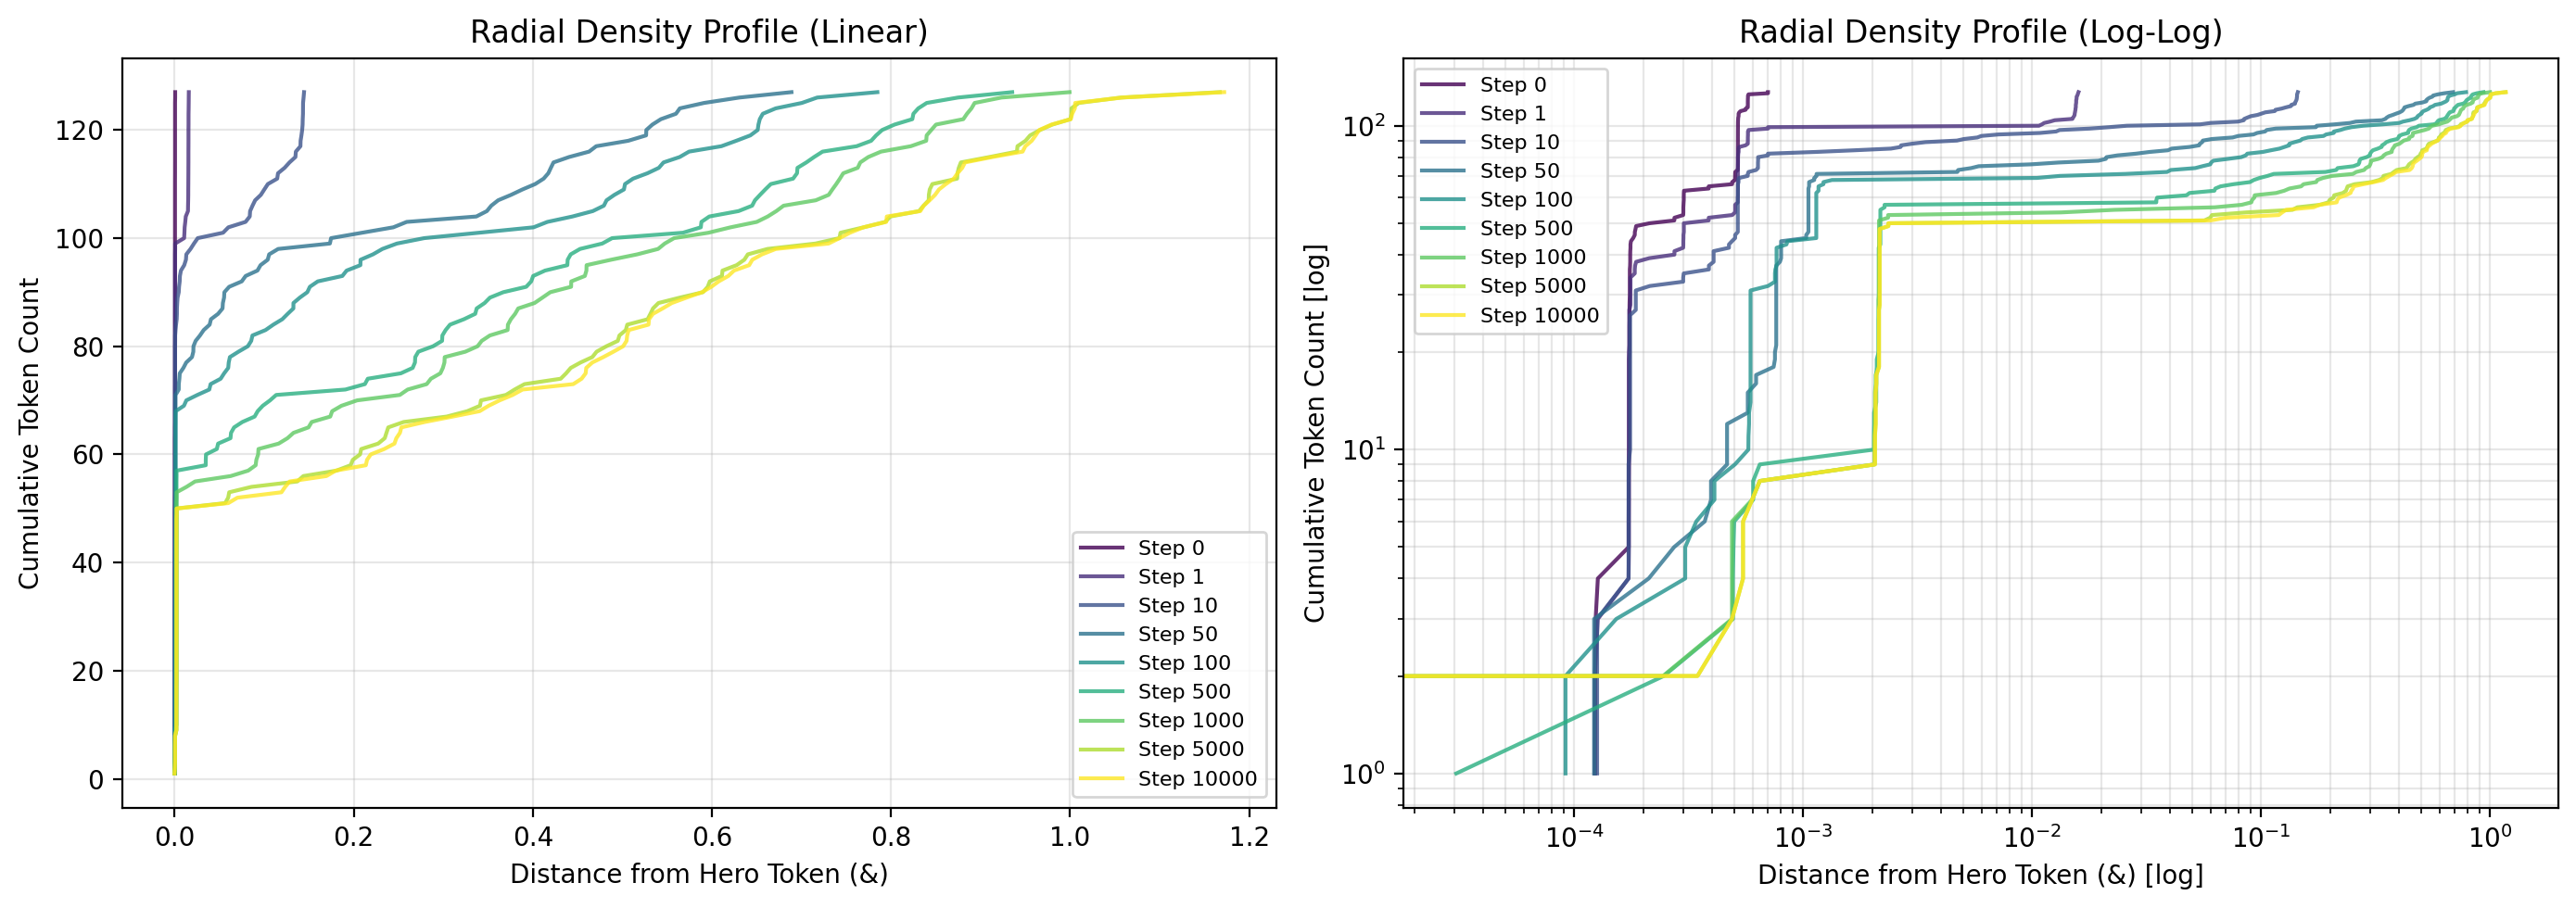

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Color map for time evolution
colors = plt.cm.viridis(np.linspace(0, 1, len(step_indices)))

for i, (step_idx, color) in enumerate(zip(step_indices, colors)):
    distances = profiles[step_idx]
    counts = np.arange(1, len(distances) + 1)
    actual_step = recorded_steps[step_idx].item()
    
    # Linear scale
    ax1.plot(distances, counts, linewidth=1.5, color=color, 
             label=f'Step {actual_step}', alpha=0.8)
    
    # Log-log scale
    ax2.plot(distances, counts, linewidth=1.5, color=color, 
             label=f'Step {actual_step}', alpha=0.8)

ax1.set_xlabel('Distance from Hero Token (&)')
ax1.set_ylabel('Cumulative Token Count')
ax1.set_title('Radial Density Profile (Linear)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Distance from Hero Token (&) [log]')
ax2.set_ylabel('Cumulative Token Count [log]')
ax2.set_title('Radial Density Profile (Log-Log)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

### Core Structure: Initial vs Final State

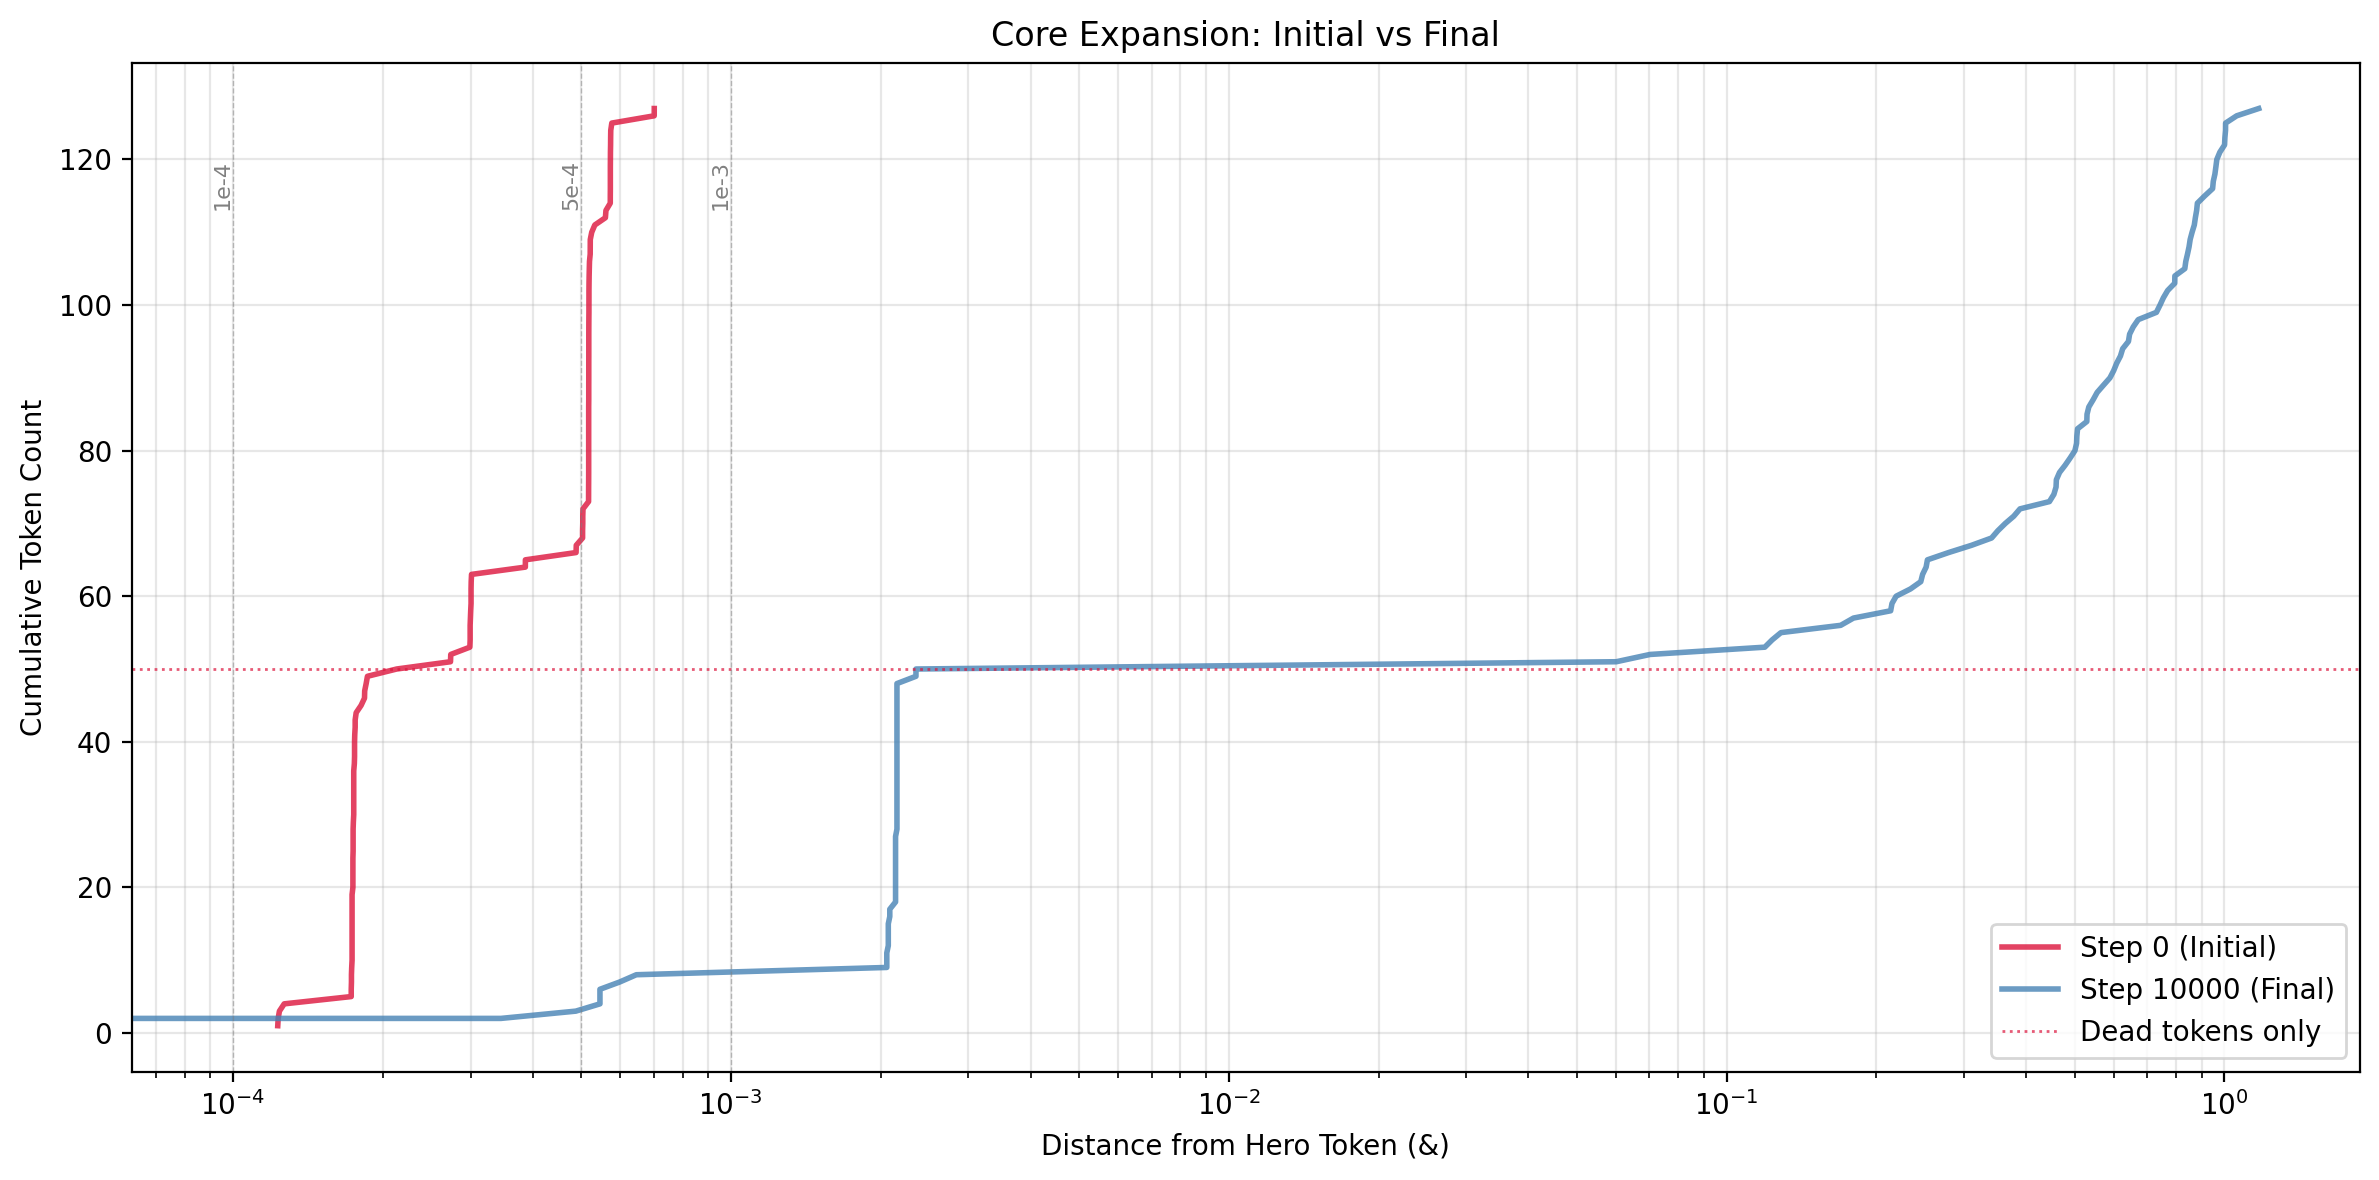

In [37]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

# Compare first and last snapshot
initial_idx = step_indices[0]
final_idx = step_indices[-1]

initial_dists = profiles[initial_idx]
final_dists = profiles[final_idx]

initial_counts = np.arange(1, len(initial_dists) + 1)
final_counts = np.arange(1, len(final_dists) + 1)

ax.plot(initial_dists, initial_counts, linewidth=2, color='crimson', 
        label=f'Step {recorded_steps[initial_idx].item()} (Initial)', alpha=0.8)
ax.plot(final_dists, final_counts, linewidth=2, color='steelblue', 
        label=f'Step {recorded_steps[final_idx].item()} (Final)', alpha=0.8)

# Mark dead token threshold
ax.axhline(50, color='crimson', linestyle=':', linewidth=1, alpha=0.7, label='Dead tokens only')

# Mark some key radii
for threshold, label in [(1e-4, '1e-4'), (5e-4, '5e-4'), (1e-3, '1e-3')]:
    ax.axvline(threshold, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.text(threshold, ax.get_ylim()[1] * 0.9, label, 
            rotation=90, va='top', ha='right', fontsize=8, color='gray')

ax.set_xlabel('Distance from Hero Token (&)')
ax.set_ylabel('Cumulative Token Count')
ax.set_title('Core Expansion: Initial vs Final')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

### Identify Core Boundary

Look for the "knee" in the curve—the radius where the slope changes sharply.

In [38]:
def find_knee(distances, counts, window=5):
    """
    Find the knee point using maximum curvature.
    
    Returns:
        knee_idx: index of knee point
        knee_radius: distance at knee
        knee_count: count at knee
    """
    # Compute second derivative (curvature)
    # Smooth first to reduce noise
    from scipy.ndimage import uniform_filter1d
    
    # Log-transform for better sensitivity
    log_dists = np.log10(distances + 1e-10)
    log_counts = np.log10(counts)
    
    # Smooth
    log_counts_smooth = uniform_filter1d(log_counts, size=window)
    
    # Second derivative
    d2 = np.diff(np.diff(log_counts_smooth))
    
    # Find maximum (most positive curvature = sharpest upward bend)
    knee_idx = np.argmax(d2) + 1  # +1 to account for diff
    
    return knee_idx, distances[knee_idx], counts[knee_idx]

print(f"\n{'='*80}")
print(f"CORE BOUNDARY IDENTIFICATION")
print(f"{'='*80}\n")

for i, step_idx in enumerate([step_indices[0], step_indices[-1]]):
    actual_step = recorded_steps[step_idx].item()
    distances = profiles[step_idx]
    counts = np.arange(1, len(distances) + 1)
    
    knee_idx, knee_r, knee_n = find_knee(distances, counts)
    
    label = "Initial" if i == 0 else "Final"
    print(f"{label} (Step {actual_step}):")
    print(f"  Core radius (knee): {knee_r:.6f}")
    print(f"  Tokens in core: {int(knee_n)}")
    print(f"  Tokens beyond core: {n_tokens - 1 - int(knee_n)}")
    print()

print(f"{'='*80}")


CORE BOUNDARY IDENTIFICATION

Initial (Step 0):
  Core radius (knee): 0.000123
  Tokens in core: 2
  Tokens beyond core: 125

Final (Step 10000):
  Core radius (knee): 0.000345
  Tokens in core: 2
  Tokens beyond core: 125



### Distance Histogram at Final Step

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_33458/3446429245.py:6: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(final_dists.min()), np.log10(final_dists.max()), 50)
/Users/jefferyharrell/Projects/Azimuth_II/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/jefferyharrell/Projects/Azimuth_II/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start


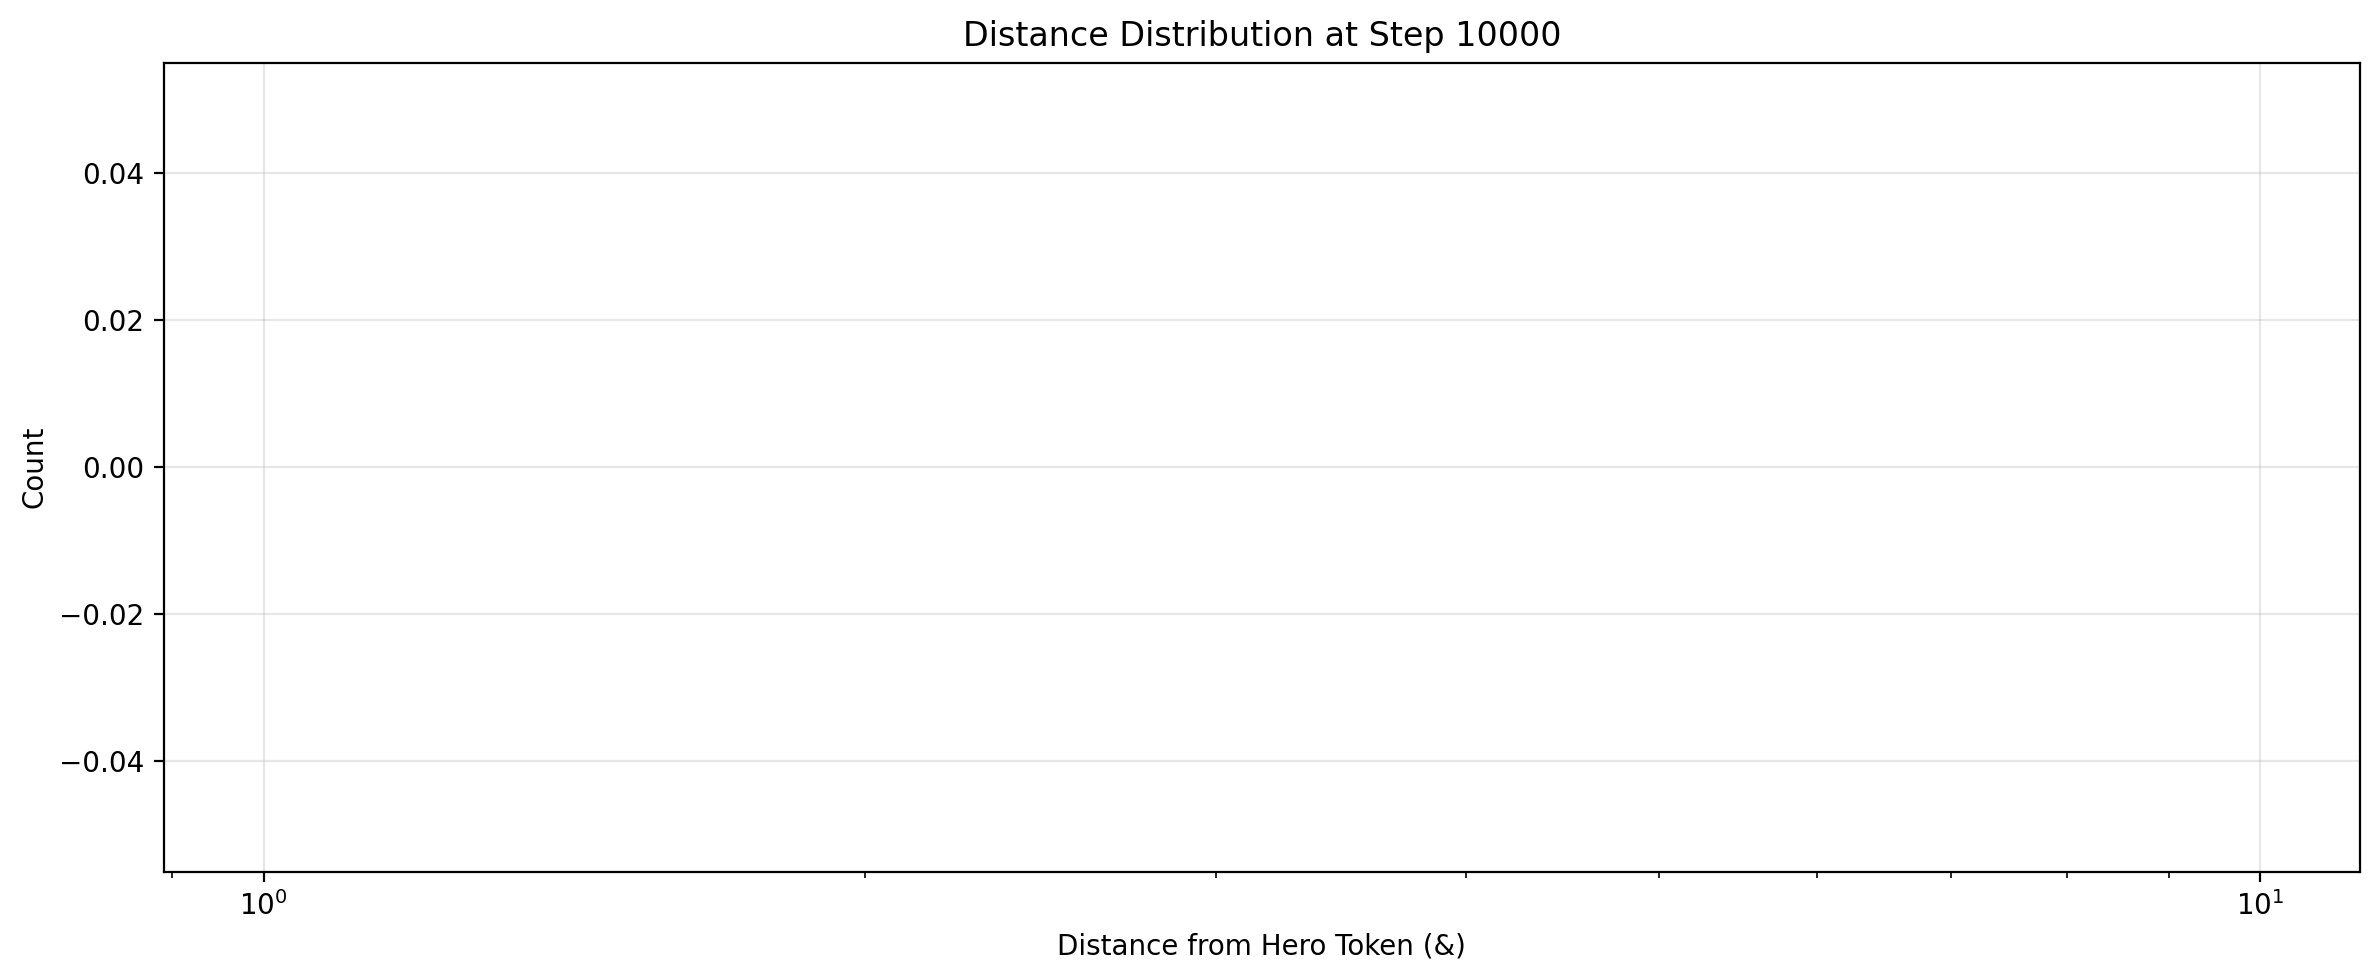


Look for gaps in the histogram—these are the natural boundaries between populations.


In [39]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

final_dists = profiles[step_indices[-1]]

# Log-spaced bins
bins = np.logspace(np.log10(final_dists.min()), np.log10(final_dists.max()), 50)

ax.hist(final_dists, bins=bins, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Distance from Hero Token (&)')
ax.set_ylabel('Count')
ax.set_title(f'Distance Distribution at Step {recorded_steps[step_indices[-1]].item()}')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLook for gaps in the histogram—these are the natural boundaries between populations.")

## Done

In [40]:
print("✓ Radial density analysis complete")

✓ Radial density analysis complete
